**TODO: put (parts of) this into paper and/or README.**

How parameter tuning works in our case:

Each evaluator has one or two numerical parameters that can be "tuned" in order to minimize a certain error. However, we have no mathematical model that can be trained in the classical ML sense. Instead, for every service, we try parameters from a parameter grid and consider this as "training" or "tuning".

We train the parameters using a 5-fold cross validation and report the average error on the test sets as the optimal error that can be achieved.

To make the tuning comparable across services, we randomly select a constant number of parameters for each service; we then repeat the 5-fold CV 10 times to make sure that the results are stable. 

In [1]:
import pandas as pd
import numpy as np
from collections import OrderedDict, Counter
from evaluators import *
from evaluator import *
from helpers import REGISTERED_EVALUATORS

import matplotlib.ticker as mtick
from mpltools import style
style.use('ggplot')
from matplotlib.ticker import FuncFormatter

import seaborn as sns
sns.set(color_codes=True)
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/helena.mihaljevic-br/.virtualenvs/name-based-inference/lib/python3.5/site-packages/mpltools/style/__init__.py:42: FutureWarning: 

    The style-sheet functionality in mpltools has been integrated into
    Matplotlib >= 1.4. This module will be removed in a future release.

    Note that style-sheets used by `matplotlib.style` use the standard
    Matplotlib rc-file syntax instead of the INI format used by `mpltools`.
    This mostly means un-quoting strings and changing '=' to ':'.


  """, FutureWarning)
/Users/helena.mihaljevic-br/.virtualenvs/name-based-inference/lib/python3.5/site-packages/matplotlib/__init__.py:800: MatplotlibDeprecationWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  mplDeprecation)
/Users/helena.mihaljevic-br/.virtualenvs/name-based-inference/lib/python3.5/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['shuffle', 'style']
`%matplotlib` prevents i

## Compute errors without tuning

In [2]:
def compute_all_errors_without_tuning():
    service_to_all_errors = {}
    error_names = ['error_with_unknown', 'error_without_unknown', 'error_gender_bias', 'error_unknown', 
                  'weighted_error']
    
    for s in REGISTERED_EVALUATORS:  
        evaluator = s('all')
        eval_name = evaluator.gender_evaluator
        evaluator.load_data(evaluated=True)
        evaluator._translate_api_response()
        evaluator.compute_confusion_matrix(evaluator.test_data)
        errors = evaluator.compute_all_errors()
        service_to_all_errors[eval_name] = errors
    all_errors = pd.DataFrame.from_dict(service_to_all_errors, orient='index')
    all_errors.columns = error_names
    return all_errors

In [3]:
errors_without_gender_bias = ['error_with_unknown', 'error_without_unknown', 'error_unknown', 'weighted_error']

In [4]:
# for the paper?
cm = sns.light_palette("green", as_cmap=True)
df = compute_all_errors_without_tuning()

df.style.background_gradient(cmap=cm)

,error_with_unknown,error_without_unknown,error_gender_bias,error_unknown,weighted_error
gender_guesser,0.229361,0.0352432,0.00540541,0.201209,0.081515
genderize_io,0.150432,0.0589248,0.0252535,0.0972366,0.0787699
gender_api_full,0.204145,0.077108,-0.0190266,0.137651,0.105659
names_api_full,0.186874,0.0432839,0.00711238,0.150086,0.0759205
gender_api,0.0867012,0.0584046,-0.00819088,0.0300518,0.0642033
names_api,0.237997,0.0501615,0.010549,0.197755,0.0947887
namsor,0.135924,0.0513841,0.0100493,0.0891192,0.0695901


In [5]:
# for the paper?
cm = sns.light_palette("green", as_cmap=True)
df = compute_all_errors_without_tuning()
df = df[errors_without_gender_bias]

df.style.background_gradient(cmap=cm)

,error_with_unknown,error_without_unknown,error_unknown,weighted_error
gender_guesser,0.229361,0.0352432,0.201209,0.081515
genderize_io,0.150432,0.0589248,0.0972366,0.0787699
gender_api_full,0.204145,0.077108,0.137651,0.105659
names_api_full,0.186874,0.0432839,0.150086,0.0759205
gender_api,0.0867012,0.0584046,0.0300518,0.0642033
names_api,0.237997,0.0501615,0.197755,0.0947887
namsor,0.135924,0.0513841,0.0891192,0.0695901


## Plot distributions of the tuning parameters

Seaborn does not work with matplotlib subplots and its own grids are not applicable here. Matplotlib on the other hand has no good plots of bivariate distributions. Hence plotting each of the seven distributions separately...

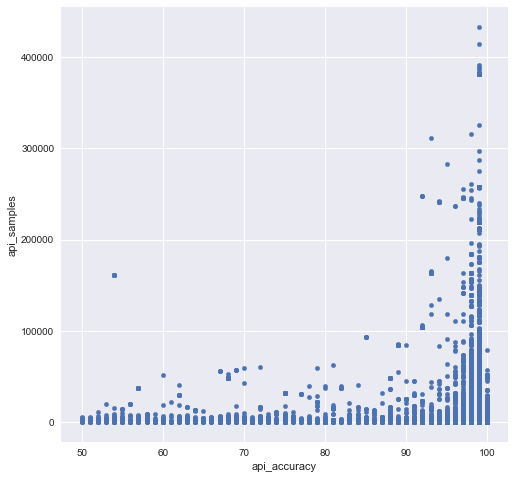

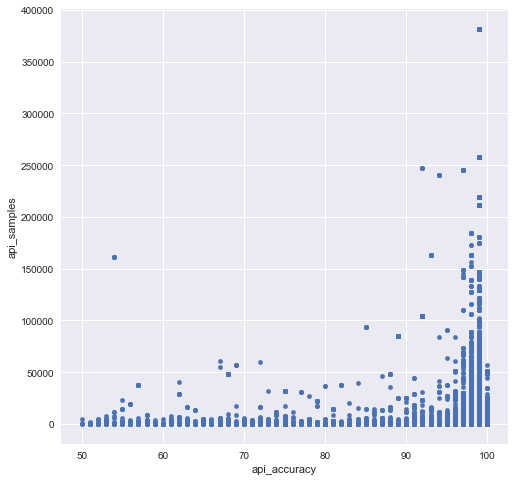

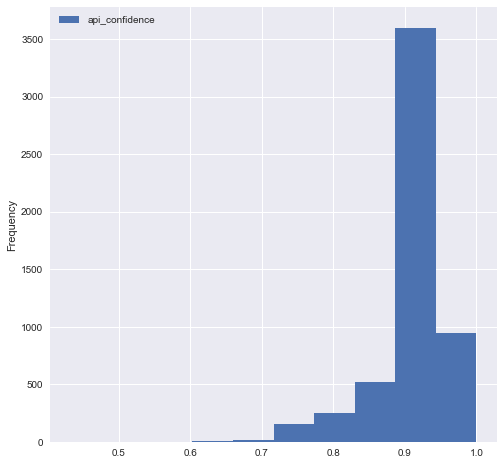

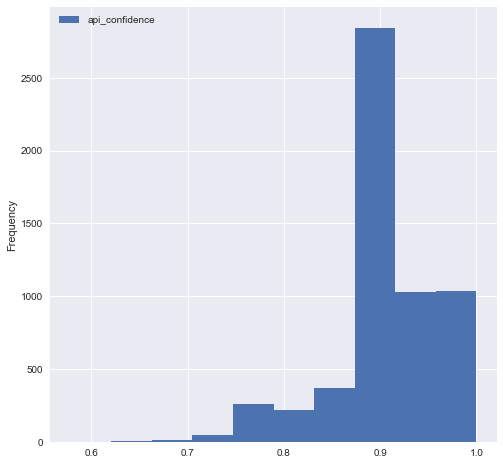

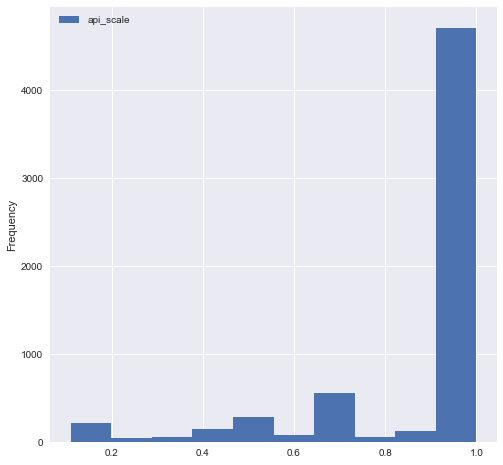

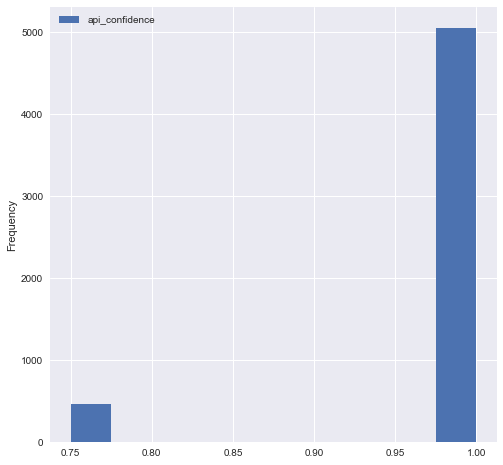

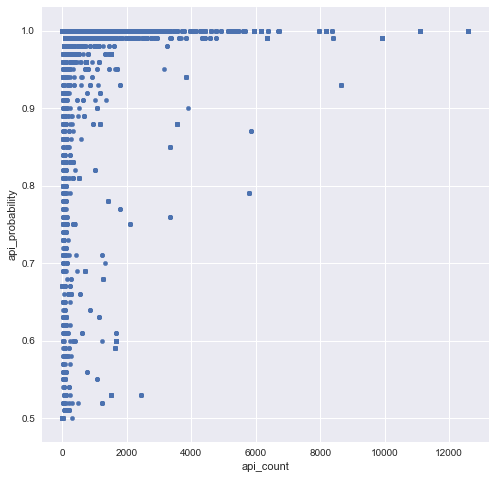

In [6]:
for s in REGISTERED_EVALUATORS:
    evaluator = s('all')
    evaluator.load_data(evaluated=True)
    evaluator.preprocess_tuning_params()
    evaluator._translate_api_response()
    evaluator.remove_rows_with_unknown_gender(gender=False, gender_infered=True)

    if len(evaluator.tuning_params) == 1:
        evaluator.test_data[evaluator.tuning_params].plot(kind='hist', figsize=(8,8))
    else:
        param_1, param_2 = evaluator.tuning_params[0], evaluator.tuning_params[1]
        evaluator.test_data.plot.scatter(x=param_1,  y=param_2, figsize=(8,8))

## Random parameter sampling for all services

In [7]:
# sample usage
s = REGISTERED_EVALUATORS[0]
evaluator = s('all')
eval_name = evaluator.gender_evaluator
evaluator.load_data(evaluated=True)
evaluator.preprocess_tuning_params()
evaluator._translate_api_response()
evaluator.remove_rows_with_unknown_gender(gender=False, gender_infered=True)

evaluator.sample_parameters(n_iter=3)

[{'api_accuracy': 84, 'api_samples': 30500},
 {'api_accuracy': 96, 'api_samples': 1902},
 {'api_accuracy': 96, 'api_samples': 11},
 {'api_accuracy': 99, 'api_samples': 68146},
 {'api_accuracy': 99, 'api_samples': 131879},
 {'api_accuracy': 99, 'api_samples': 29},
 {'api_accuracy': 99, 'api_samples': 16},
 {'api_accuracy': 99, 'api_samples': 42553},
 {'api_accuracy': 93, 'api_samples': 9},
 {'api_accuracy': 0, 'api_samples': 0}]

In [8]:
def sample_parameters_for_all_services(n_iter=20, method='square', random_state=None):
    service_to_param_range = {}
    for s in REGISTERED_EVALUATORS:  
        evaluator = s('all')
        evaluator.load_data(evaluated=True)
        evaluator.preprocess_tuning_params()
        evaluator._translate_api_response()
        evaluator.remove_rows_with_unknown_gender(gender=False, gender_infered=True)
        
        service_to_param_range[evaluator.gender_evaluator] = evaluator.sample_parameters(n_iter=n_iter, 
                                                                                         method=method, 
                                                                                         random_state=random_state)
        
    return service_to_param_range

In [9]:
grid_20_20 = sample_parameters_for_all_services(n_iter=20, method="constant")
grid_30_30 = sample_parameters_for_all_services(n_iter=30, method="constant")
grid_50_50 = sample_parameters_for_all_services(n_iter=50, method="constant")
grid_100_100 = sample_parameters_for_all_services(n_iter=100, method="constant")
grid_200_200 = sample_parameters_for_all_services(n_iter=200, method="constant")

grid_20_400 = sample_parameters_for_all_services(n_iter=20, method="square")

In [10]:
# check size of grid per service
dict_of_grids = {"a: 20-20": grid_20_20, "b: 30-30": grid_30_30, "c: 50-50": grid_50_50, 
                             "d: 100-100": grid_100_100, "e: 200-200": grid_200_200, "f: 20-400": grid_20_400}

dict_of_grids = OrderedDict(sorted(dict_of_grids.items(), key=lambda t: t[0]))

for grid_size, service_to_grid in dict_of_grids.items():
    print(grid_size)
    for service, grid in service_to_grid.items():
        print(service, len(grid))

a: 20-20
gender_guesser 3
genderize_io 21
gender_api_full 21
names_api_full 15
gender_api 21
names_api 13
namsor 7
b: 30-30
gender_guesser 3
genderize_io 30
gender_api_full 31
names_api_full 17
gender_api 31
names_api 22
namsor 8
c: 50-50
gender_guesser 3
genderize_io 49
gender_api_full 51
names_api_full 31
gender_api 51
names_api 29
namsor 13
d: 100-100
gender_guesser 3
genderize_io 98
gender_api_full 97
names_api_full 45
gender_api 100
names_api 45
namsor 23
e: 200-200
gender_guesser 3
genderize_io 178
gender_api_full 198
names_api_full 86
gender_api 197
names_api 70
namsor 27
f: 20-400
gender_guesser 3
genderize_io 313
gender_api_full 386
names_api_full 17
gender_api 379
names_api 13
namsor 7


We see the following:

* for `gender_guesser` there are at most 3 parameter values anyway so exhaustive search of parameter space is reached
* the `namsor` parameter space is quite sparse, hence the grid size does not grow as fast; the other 1-parameter service `names_api` (and `names_api_full`) profits more
* the grid sizes for the 2-parameter services `gender_api` (and `gender_api_full`) and `genderize_io` grow almost to the limit of the allowed grid size

In [11]:
grid_20_20['gender_api']

[{'api_accuracy': 96, 'api_samples': 1597},
 {'api_accuracy': 99, 'api_samples': 139211},
 {'api_accuracy': 75, 'api_samples': 65299},
 {'api_accuracy': 71, 'api_samples': 1478},
 {'api_accuracy': 98, 'api_samples': 20555},
 {'api_accuracy': 99, 'api_samples': 163699},
 {'api_accuracy': 77, 'api_samples': 416},
 {'api_accuracy': 72, 'api_samples': 20},
 {'api_accuracy': 99, 'api_samples': 1491},
 {'api_accuracy': 98, 'api_samples': 2108},
 {'api_accuracy': 97, 'api_samples': 3288},
 {'api_accuracy': 98, 'api_samples': 54216},
 {'api_accuracy': 98, 'api_samples': 2934},
 {'api_accuracy': 97, 'api_samples': 24},
 {'api_accuracy': 100, 'api_samples': 35767},
 {'api_accuracy': 99, 'api_samples': 9874},
 {'api_accuracy': 100, 'api_samples': 32478},
 {'api_accuracy': 53, 'api_samples': 44677},
 {'api_accuracy': 98, 'api_samples': 22261},
 {'api_accuracy': 99, 'api_samples': 5},
 {'api_accuracy': 0, 'api_samples': 0}]

In [12]:
grid_20_20['gender_guesser']

[{'api_confidence': 1.0}, {'api_confidence': 0.75}, {'api_confidence': 0}]

## Benchmark by repeated cross validation

The larger the number of parameter values the smaller the error on the train set. however, choosing too many parameter values makes it harder to compare services with very few parameters and those with many, and it increases the probability of overfitting.

Hence we choose rather small parameter lists but repeat the 5-fold cross validation 10 times and count, who came first (second) how often. This ensures higher stability in the results.

In [33]:
# Wrapper around some methods to make tuning with different error functions a one-liner
def prepare_for_tuning(e):
    e.load_data(evaluated=True)
    e.preprocess_tuning_params()
    e._translate_api_response()
    e.remove_rows_with_unknown_gender(gender=True, gender_infered=False)
    e.shuffle_data()
    return e

def tune(error_func, param_ranges, constraint_func=None, constraint_val=None, verbose=True):
    service_to_test_error = {}
    for s in REGISTERED_EVALUATORS:  
        evaluator = s('all')
        evaluator_name = evaluator.gender_evaluator
        print(evaluator_name)

        evaluator = prepare_for_tuning(evaluator)
        
        param_range = param_ranges[evaluator_name]
        mean_test_error = evaluator.compute_k_fold_cv_score(n_splits=5, param_range=param_range, error_func=error_func, 
                                                    constraint_func=constraint_func, constraint_val=constraint_val, 
                                                    verbose=verbose)
        service_to_test_error[evaluator_name] = mean_test_error
    return service_to_test_error

def tune_repeat(error_func, n_params, n_repeat=10, constraint_func=None, constraint_val=None, verbose=False):
    service_to_test_error_repeat = []
    for i in range(n_repeat):
        param_ranges = sample_parameters_for_all_services(n_iter=n_params, method='constant', random_state=i)
        service_to_test_error = tune(error_func, param_ranges, constraint_func=constraint_func, 
                                                  constraint_val=constraint_val, verbose=verbose)
        service_to_test_error_repeat.append(list(sorted(service_to_test_error.items(), key=lambda t: t[1])))
    return service_to_test_error_repeat

def explore_benchmark(benchmark):
    """Determine services that made it to the first and second place, and create dataframe with their CV errors 
    in each of the repetitions."""
    first_service, second_service = [], []
    for i, item in enumerate(benchmark):
        # print("first place in iteration round ", i, " :", item[0])
        # print("second place in iteration round ", i, " :", item[1])
        first_service.append(item[0][0])
        second_service.append(item[1][0])

    errors_per_service_and_iteration = pd.DataFrame.from_dict([{i[0]:i[1] for i in item} for item in benchmark])

    print("Services at place 1:", Counter(first_service))
    print("Services at place 2:", Counter(second_service))
    display(errors_per_service_and_iteration)
    return errors_per_service_and_iteration

### Benchmark 1: minimize `error_with_unknown` with the constraint  `error_without_unknown < 0.05`
This benchmark means that the error of classifying women as men or 'unknown' and classifying men as women or 'unknown' is to be minimized, under the constraint that at most 5% of those classified as men or women have been missclassified.

In [14]:
benchmark_1 = tune_repeat(error_func=Evaluator.compute_error_with_unknown, n_params=30, n_repeat=10, 
                          constraint_func=Evaluator.compute_error_without_unknown, constraint_val=0.05, verbose=True)

gender_api
minimal train error: 0.127402288922 corresponding test error: 0.135461604832
params for lowest train error: {'api_samples': 3281, 'api_accuracy': 81}
minimal train error: 0.088298791019 corresponding test error: 0.080310880829
params for lowest train error: {'api_samples': 0, 'api_accuracy': 0}
minimal train error: 0.104706390328 corresponding test error: 0.115716753022
params for lowest train error: {'api_samples': 38223, 'api_accuracy': 65}
minimal train error: 0.0898100172712 corresponding test error: 0.0768566493955
params for lowest train error: {'api_samples': 32, 'api_accuracy': 57}
minimal train error: 0.100798618606 corresponding test error: 0.106309420916
params for lowest train error: {'api_samples': 3438, 'api_accuracy': 66}
Average test error: 0.102931061799
gender_api_full
minimal train error: 0.257179874757 corresponding test error: 0.270923209664
params for lowest train error: {'api_samples': 68146, 'api_accuracy': 78}
minimal train error: 0.26079447323 corre

minimal train error: 0.160224573526 corresponding test error: 0.173425366695
params for lowest train error: {'api_scale': 0.40999999999999998}
minimal train error: 0.14097582038 corresponding test error: 0.115716753022
params for lowest train error: {'api_scale': 0.13}
minimal train error: 0.135362694301 corresponding test error: 0.13816925734
params for lowest train error: {'api_scale': 0.13}
minimal train error: 0.160837651123 corresponding test error: 0.170984455959
params for lowest train error: {'api_scale': 0.40999999999999998}
minimal train error: 0.161882149795 corresponding test error: 0.166810717373
params for lowest train error: {'api_scale': 0.40999999999999998}
Average test error: 0.153021310078
gender_guesser
minimal train error: 0.228460375729 corresponding test error: 0.2329594478
params for lowest train error: {'api_confidence': 0.75}
minimal train error: 0.227547495682 corresponding test error: 0.236614853195
params for lowest train error: {'api_confidence': 0.75}
min

minimal train error: 0.262794212913 corresponding test error: 0.276962899051
params for lowest train error: {'api_samples': 44680, 'api_accuracy': 80}
minimal train error: 0.26597582038 corresponding test error: 0.258203799655
params for lowest train error: {'api_samples': 11999, 'api_accuracy': 81}
minimal train error: 0.265544041451 corresponding test error: 0.259930915371
params for lowest train error: {'api_samples': 11999, 'api_accuracy': 81}
minimal train error: 0.260362694301 corresponding test error: 0.280656303972
params for lowest train error: {'api_samples': 11999, 'api_accuracy': 81}
minimal train error: 0.267860997194 corresponding test error: 0.250648228176
params for lowest train error: {'api_samples': 11999, 'api_accuracy': 81}
Average test error: 0.265280429245
names_api
minimal train error: 0.928093284388 corresponding test error: 0.933563416739
params for lowest train error: {'api_confidence': 1.0}
minimal train error: 0.24481865285 corresponding test error: 0.210708

minimal train error: 0.232081174439 corresponding test error: 0.218480138169
params for lowest train error: {'api_confidence': 0.75}
minimal train error: 0.229058721934 corresponding test error: 0.230569948187
params for lowest train error: {'api_confidence': 0.75}
minimal train error: 0.229656809842 corresponding test error: 0.228176318064
params for lowest train error: {'api_confidence': 0.75}
Average test error: 0.229360141083
genderize_io
minimal train error: 0.212697041676 corresponding test error: 0.246764452114
params for lowest train error: {'api_count': 460.0, 'api_probability': 0.95999999999999996}
minimal train error: 0.153281519862 corresponding test error: 0.139032815199
params for lowest train error: {'api_count': 0, 'api_probability': 0}
minimal train error: 0.210276338515 corresponding test error: 0.218480138169
params for lowest train error: {'api_count': 80.0, 'api_probability': 1.0}
minimal train error: 0.153281519862 corresponding test error: 0.145941278066
params f

minimal train error: 0.24481865285 corresponding test error: 0.210708117444
params for lowest train error: {'api_confidence': 0}
minimal train error: 0.235535405872 corresponding test error: 0.247841105354
params for lowest train error: {'api_confidence': 0}
minimal train error: 0.240716753022 corresponding test error: 0.227115716753
params for lowest train error: {'api_confidence': 0}
minimal train error: 0.2369954673 corresponding test error: 0.242005185825
params for lowest train error: {'api_confidence': 0}
Average test error: 0.372246708423
names_api_full
minimal train error: 0.183761606564 corresponding test error: 0.199309749784
params for lowest train error: {'api_confidence': 0}
minimal train error: 0.192141623489 corresponding test error: 0.165803108808
params for lowest train error: {'api_confidence': 0}
minimal train error: 0.184153713299 corresponding test error: 0.197754749568
params for lowest train error: {'api_confidence': 0}
minimal train error: 0.189550949914 corresp

minimal train error: 0.178972366149 corresponding test error: 0.194300518135
params for lowest train error: {'api_count': 192.0, 'api_probability': 0.82999999999999996}
minimal train error: 0.153281519862 corresponding test error: 0.145941278066
params for lowest train error: {'api_count': 3.0, 'api_probability': 1.0}
minimal train error: 0.160802935463 corresponding test error: 0.160760587727
params for lowest train error: {'api_count': 1631.0, 'api_probability': 0.58999999999999997}
Average test error: 0.167523864674
gender_api
minimal train error: 0.148779961132 corresponding test error: 0.157031924072
params for lowest train error: {'api_samples': 3874, 'api_accuracy': 89}
minimal train error: 0.088298791019 corresponding test error: 0.080310880829
params for lowest train error: {'api_samples': 0, 'api_accuracy': 0}
minimal train error: 0.148316062176 corresponding test error: 0.158894645941
params for lowest train error: {'api_samples': 3874, 'api_accuracy': 89}
minimal train erro

minimal train error: 0.192141623489 corresponding test error: 0.165803108808
params for lowest train error: {'api_confidence': 0}
minimal train error: 0.184153713299 corresponding test error: 0.197754749568
params for lowest train error: {'api_confidence': 0}
minimal train error: 0.189550949914 corresponding test error: 0.176165803109
params for lowest train error: {'api_confidence': 0}
minimal train error: 0.184761493633 corresponding test error: 0.195332757131
params for lowest train error: {'api_confidence': 0}
Average test error: 0.18687323368
namsor
minimal train error: 0.174476354999 corresponding test error: 0.183779119931
params for lowest train error: {'api_scale': 0.5}
minimal train error: 0.14097582038 corresponding test error: 0.115716753022
params for lowest train error: {'api_scale': 0}
minimal train error: 0.135362694301 corresponding test error: 0.13816925734
params for lowest train error: {'api_scale': 0}
minimal train error: 0.17530224525 corresponding test error: 0.1

**Note: for some services, in particular 'NamesAPI', the constraint is not always satisfied and the following line is in the print: 'No parameter values satisfied given constraint'. In this case, test_error=1 is returned. **

In [18]:
benchmark_1[0]

[('gender_api', 0.1029310617989783),
 ('namsor', 0.14870351821002115),
 ('genderize_io', 0.17217903015093641),
 ('names_api_full', 0.18687323368002523),
 ('gender_guesser', 0.22936014108294717),
 ('gender_api_full', 0.25992651799535443),
 ('names_api', 0.38553402507527212)]

In [35]:
errors_per_service_and_iteration_1 = explore_benchmark(benchmark_1)

Services at place 1: Counter({'gender_api': 10})
Services at place 2: Counter({'namsor': 10})


,gender_api,gender_api_full,gender_guesser,genderize_io,names_api,names_api_full,namsor
0,0.102931,0.259927,0.22936,0.172179,0.385534,0.186873,0.148704
1,0.102764,0.271153,0.22936,0.169254,0.372247,0.186873,0.153021
2,0.106041,0.251114,0.22936,0.168904,0.372247,0.186873,0.149222
3,0.105002,0.265280,0.22936,0.167527,0.372247,0.186873,0.160622
4,0.102242,0.259581,0.22936,0.182369,0.372247,0.186873,0.153367
5,0.120208,0.277543,0.22936,0.166487,0.372247,0.186873,0.160622
6,0.116229,0.260958,0.22936,0.163723,0.372247,0.186873,0.160622
7,0.105351,0.270974,0.22936,0.167524,0.372247,0.186873,0.159585
8,0.126420,0.256988,0.22936,0.172185,0.372247,0.186873,0.155267
9,0.127622,0.248698,0.22936,0.170290,0.385534,0.186873,0.160622


In [36]:
errors_per_service_and_iteration_1.describe()

,gender_api,gender_api_full,gender_guesser,genderize_io,names_api,names_api_full,namsor
count,10.000000,10.000000,1.000000e+01,10.000000,10.000000,10.000000,10.000000
mean,0.111481,0.262222,2.293601e-01,0.170044,0.374904,0.186873,0.156165
std,0.010143,0.009116,2.925695e-17,0.005037,0.005602,0.000000,0.004871
min,0.102242,0.248698,2.293601e-01,0.163723,0.372247,0.186873,0.148704
25%,0.103449,0.257636,2.293601e-01,0.167525,0.372247,0.186873,0.153108
50%,0.105696,0.260442,2.293601e-01,0.169079,0.372247,0.186873,0.157426
75%,0.119213,0.269551,2.293601e-01,0.171707,0.372247,0.186873,0.160622
max,0.127622,0.277543,2.293601e-01,0.182369,0.385534,0.186873,0.160622


### Benchmark 2: minimize `error_without_unknown` with the constraint  `error_unknown < 0.2`
This benchmark can be interpreted as follows: minimize the error of classifying women as men and vice versa, but under the constraint that at most 20% are left as 'unknown'. 

In [38]:
benchmark_2 = tune_repeat(error_func=Evaluator.compute_error_without_unknown, n_params=30, n_repeat=10, 
                     constraint_func=Evaluator.compute_error_unknown, constraint_val=0.25, verbose=True)

gender_api
minimal train error: 0.0138734739179 corresponding test error: 0.0220750551876
params for lowest train error: {'api_samples': 56140, 'api_accuracy': 95}
minimal train error: 0.0159128978224 corresponding test error: 0.0140086206897
params for lowest train error: {'api_samples': 56140, 'api_accuracy': 95}
minimal train error: 0.016275862069 corresponding test error: 0.0124293785311
params for lowest train error: {'api_samples': 56140, 'api_accuracy': 95}
minimal train error: 0.0158113730929 corresponding test error: 0.014364640884
params for lowest train error: {'api_samples': 56140, 'api_accuracy': 95}
minimal train error: 0.0157284768212 corresponding test error: 0.0146726862302
params for lowest train error: {'api_samples': 56140, 'api_accuracy': 95}
Average test error: 0.0155100763045
gender_api_full
minimal train error: 0.0398540555711 corresponding test error: 0.0433295324971
params for lowest train error: {'api_samples': 219085, 'api_accuracy': 79}
minimal train error:

minimal train error: 0.0387638926538 corresponding test error: 0.0403489640131
params for lowest train error: {'api_confidence': 0.80918400000000001}
minimal train error: 0.0401301518438 corresponding test error: 0.0348583877996
params for lowest train error: {'api_confidence': 0.80918400000000001}
minimal train error: 0.0381700054142 corresponding test error: 0.0427631578947
params for lowest train error: {'api_confidence': 0.80918400000000001}
Average test error: 0.0380240403733
namsor
minimal train error: 0.019693654267 corresponding test error: 0.0298672566372
params for lowest train error: {'api_scale': 0.70999999999999996}
minimal train error: 0.0234612199834 corresponding test error: 0.0149413020277
params for lowest train error: {'api_scale': 0.70999999999999996}
minimal train error: 0.0215905985242 corresponding test error: 0.0221975582686
params for lowest train error: {'api_scale': 0.70999999999999996}
minimal train error: 0.0222222222222 corresponding test error: 0.01967213

minimal train error: 0.0203619909502 corresponding test error: 0.0238907849829
params for lowest train error: {'api_count': 4381.0, 'api_probability': 0.95999999999999996}
Average test error: 0.0239185348154
gender_api
minimal train error: 0.0124964498722 corresponding test error: 0.0192962542565
params for lowest train error: {'api_samples': 63411, 'api_accuracy': 96}
minimal train error: 0.0143061516452 corresponding test error: 0.0121278941566
params for lowest train error: {'api_samples': 63411, 'api_accuracy': 96}
minimal train error: 0.0165876777251 corresponding test error: 0.0160427807487
params for lowest train error: {'api_samples': 130215, 'api_accuracy': 91}
minimal train error: 0.0139402560455 corresponding test error: 0.0135287485908
params for lowest train error: {'api_samples': 63411, 'api_accuracy': 96}
minimal train error: 0.0160653147221 corresponding test error: 0.0181623931624
params for lowest train error: {'api_samples': 130215, 'api_accuracy': 91}
Average test e

minimal train error: 0.0399460188934 corresponding test error: 0.0389473684211
params for lowest train error: {'api_confidence': 0.79851000000000005}
minimal train error: 0.0397102226992 corresponding test error: 0.0398706896552
params for lowest train error: {'api_confidence': 0.79851000000000005}
minimal train error: 0.0410628019324 corresponding test error: 0.0344456404736
params for lowest train error: {'api_confidence': 0.79851000000000005}
minimal train error: 0.0388219544846 corresponding test error: 0.0434782608696
params for lowest train error: {'api_confidence': 0.79851000000000005}
Average test error: 0.0397535642977
namsor
minimal train error: 0.019693654267 corresponding test error: 0.0298672566372
params for lowest train error: {'api_scale': 0.70999999999999996}
minimal train error: 0.0234612199834 corresponding test error: 0.0149413020277
params for lowest train error: {'api_scale': 0.70999999999999996}
minimal train error: 0.0215905985242 corresponding test error: 0.022

minimal train error: 0.0208333333333 corresponding test error: 0.0263459335624
params for lowest train error: {'api_count': 2400.0, 'api_probability': 0.96999999999999997}
Average test error: 0.0249884493541
gender_api
minimal train error: 0.0159811370186 corresponding test error: 0.0252100840336
params for lowest train error: {'api_samples': 219085, 'api_accuracy': 90}
minimal train error: 0.0192409066948 corresponding test error: 0.0123076923077
params for lowest train error: {'api_samples': 219085, 'api_accuracy': 90}
minimal train error: 0.0175163398693 corresponding test error: 0.0190677966102
params for lowest train error: {'api_samples': 219085, 'api_accuracy': 90}
minimal train error: 0.0191199580932 corresponding test error: 0.01261829653
params for lowest train error: {'api_samples': 219085, 'api_accuracy': 90}
minimal train error: 0.0172684458399 corresponding test error: 0.0200633579725
params for lowest train error: {'api_samples': 219085, 'api_accuracy': 90}
Average test 

minimal train error: 0.0367483296214 corresponding test error: 0.0379464285714
params for lowest train error: {'api_confidence': 0.83951200000000004}
minimal train error: 0.0372653404315 corresponding test error: 0.0359085963003
params for lowest train error: {'api_confidence': 0.83951200000000004}
minimal train error: 0.0369649805447 corresponding test error: 0.0370786516854
params for lowest train error: {'api_confidence': 0.83951200000000004}
minimal train error: 0.0375312760634 corresponding test error: 0.0347923681257
params for lowest train error: {'api_confidence': 0.83951200000000004}
minimal train error: 0.0364293659622 corresponding test error: 0.0392376681614
params for lowest train error: {'api_confidence': 0.83951200000000004}
Average test error: 0.0369927425689
namsor
minimal train error: 0.019693654267 corresponding test error: 0.0298672566372
params for lowest train error: {'api_scale': 0.70999999999999996}
minimal train error: 0.0234612199834 corresponding test error: 

minimal train error: 0.0214306400232 corresponding test error: 0.0147058823529
params for lowest train error: {'api_count': 4373.0, 'api_probability': 0.96999999999999997}
minimal train error: 0.0206993006993 corresponding test error: 0.023595505618
params for lowest train error: {'api_count': 5168.0, 'api_probability': 0.94999999999999996}
Average test error: 0.0237655321036
gender_api
minimal train error: 0.0138849532445 corresponding test error: 0.0192743764172
params for lowest train error: {'api_samples': 55041, 'api_accuracy': 96}
minimal train error: 0.0124746156078 corresponding test error: 0.0111731843575
params for lowest train error: {'api_samples': 131879, 'api_accuracy': 96}
minimal train error: 0.0163545238723 corresponding test error: 0.0160427807487
params for lowest train error: {'api_samples': 381770, 'api_accuracy': 91}
minimal train error: 0.0124098124098 corresponding test error: 0.0114025085519
params for lowest train error: {'api_samples': 131879, 'api_accuracy':

In [39]:
errors_per_service_and_iteration_2 = explore_benchmark(benchmark_2)

Services at place 1: Counter({'gender_api': 10})
Services at place 2: Counter({'namsor': 9, 'genderize_io': 1})


,gender_api,gender_api_full,gender_guesser,genderize_io,names_api,names_api_full,namsor
0,0.015510,0.040880,0.035208,0.030559,0.045971,0.036739,0.021765
1,0.021141,0.045562,0.035208,0.022546,0.049054,0.038024,0.021765
2,0.018229,0.040262,0.035208,0.023919,0.047595,0.037170,0.021765
3,0.015832,0.043119,0.035208,0.024555,0.048480,0.037109,0.021765
4,0.017145,0.042011,0.035208,0.029129,0.049054,0.039754,0.021765
5,0.016882,0.044626,0.035208,0.024988,0.049074,0.036577,0.021765
6,0.017853,0.042377,0.035208,0.037162,0.047519,0.036480,0.021765
7,0.016222,0.047240,0.035208,0.021682,0.046803,0.036993,0.021765
8,0.016615,0.042999,0.035208,0.023766,0.048515,0.043306,0.021765
9,0.015219,0.042490,0.035208,0.032690,0.047877,0.036897,0.021765


In [40]:
errors_per_service_and_iteration_2.describe()

,gender_api,gender_api_full,gender_guesser,genderize_io,names_api,names_api_full,namsor
count,10.000000,10.000000,1.000000e+01,10.000000,10.000000,10.000000,1.000000e+01
mean,0.017065,0.043157,3.520837e-02,0.027100,0.047994,0.037905,2.176533e-02
std,0.001729,0.002123,7.314236e-18,0.005064,0.001045,0.002129,3.657118e-18
min,0.015219,0.040262,3.520837e-02,0.021682,0.045971,0.036480,2.176533e-02
25%,0.015929,0.042102,3.520837e-02,0.023804,0.047538,0.036778,2.176533e-02
50%,0.016749,0.042744,3.520837e-02,0.024772,0.048179,0.037051,2.176533e-02
75%,0.017676,0.044249,3.520837e-02,0.030202,0.048920,0.037811,2.176533e-02
max,0.021141,0.047240,3.520837e-02,0.037162,0.049074,0.043306,2.176533e-02


### Benchmark 3: minimize `weighted_error`
The 'weighted error' puts 5 times more wight on classifying women as men and vice versa than classifying both of them as 'unknown'

In [41]:
benchmark_3 = tune_repeat(error_func=Evaluator.compute_weighted_error, n_params=30, n_repeat=10, verbose=True)

gender_api
minimal train error: 0.0504472102598 corresponding test error: 0.0587902769927
params for lowest train error: {'api_samples': 139211, 'api_accuracy': 76}
minimal train error: 0.0543292913983 corresponding test error: 0.0433721366879
params for lowest train error: {'api_samples': 139211, 'api_accuracy': 76}
minimal train error: 0.0506508205999 corresponding test error: 0.0580817730225
params for lowest train error: {'api_samples': 139211, 'api_accuracy': 76}
minimal train error: 0.0536322360953 corresponding test error: 0.0460899131092
params for lowest train error: {'api_samples': 139211, 'api_accuracy': 76}
minimal train error: 0.0515571097774 corresponding test error: 0.0543869622892
params for lowest train error: {'api_samples': 139211, 'api_accuracy': 76}
Average test error: 0.0521442124203
gender_api_full
minimal train error: 0.093926144445 corresponding test error: 0.100872526069
params for lowest train error: {'api_samples': 68146, 'api_accuracy': 78}
minimal train er

minimal train error: 0.0748542595405 corresponding test error: 0.0802213001383
params for lowest train error: {'api_confidence': 0}
Average test error: 0.0759725033101
namsor
minimal train error: 0.0611269373763 corresponding test error: 0.0729630346429
params for lowest train error: {'api_scale': 0.40999999999999998}
minimal train error: 0.0661337209302 corresponding test error: 0.0530736922489
params for lowest train error: {'api_scale': 0.40999999999999998}
minimal train error: 0.0642512077295 corresponding test error: 0.0604480494399
params for lowest train error: {'api_scale': 0.40999999999999998}
minimal train error: 0.0625602932664 corresponding test error: 0.0672366886902
params for lowest train error: {'api_scale': 0.40999999999999998}
minimal train error: 0.0633894543876 corresponding test error: 0.0638959021169
params for lowest train error: {'api_scale': 0.40999999999999998}
Average test error: 0.0635234734278
gender_guesser
minimal train error: 0.0790762410434 correspondin

minimal train error: 0.0515850417616 corresponding test error: 0.0578034682081
params for lowest train error: {'api_samples': 46085, 'api_accuracy': 79}
minimal train error: 0.0537516663493 corresponding test error: 0.049068086725
params for lowest train error: {'api_samples': 46085, 'api_accuracy': 79}
minimal train error: 0.0518924065699 corresponding test error: 0.0564961004375
params for lowest train error: {'api_samples': 46085, 'api_accuracy': 79}
Average test error: 0.0528455098966
gender_api_full
minimal train error: 0.0941428189355 corresponding test error: 0.101402373247
params for lowest train error: {'api_samples': 101742, 'api_accuracy': 81}
minimal train error: 0.0970437017995 corresponding test error: 0.089738085015
params for lowest train error: {'api_samples': 101742, 'api_accuracy': 81}
minimal train error: 0.0951332187366 corresponding test error: 0.0973695375477
params for lowest train error: {'api_samples': 101742, 'api_accuracy': 81}
minimal train error: 0.0954894

minimal train error: 0.0640715667311 corresponding test error: 0.0614103060829
params for lowest train error: {'api_scale': 0.42999999999999999}
minimal train error: 0.0626207962891 corresponding test error: 0.0672366886902
params for lowest train error: {'api_scale': 0.42999999999999999}
minimal train error: 0.0633302738998 corresponding test error: 0.0643843610193
params for lowest train error: {'api_scale': 0.42999999999999999}
Average test error: 0.0635714873293
gender_guesser
minimal train error: 0.0790762410434 corresponding test error: 0.0911878961358
params for lowest train error: {'api_confidence': 0.75}
minimal train error: 0.0821875641289 corresponding test error: 0.0787828261776
params for lowest train error: {'api_confidence': 0.75}
minimal train error: 0.0832474226804 corresponding test error: 0.0746421267894
params for lowest train error: {'api_confidence': 0.75}
minimal train error: 0.0817218679284 corresponding test error: 0.0806851011143
params for lowest train error:

minimal train error: 0.0945642525195 corresponding test error: 0.103049421661
params for lowest train error: {'api_samples': 28436, 'api_accuracy': 77}
minimal train error: 0.0966408539138 corresponding test error: 0.0947017104714
params for lowest train error: {'api_samples': 28436, 'api_accuracy': 77}
minimal train error: 0.0955774470761 corresponding test error: 0.0989216092908
params for lowest train error: {'api_samples': 28436, 'api_accuracy': 77}
minimal train error: 0.0956357758621 corresponding test error: 0.0979267754742
params for lowest train error: {'api_samples': 97659, 'api_accuracy': 83}
minimal train error: 0.0964411844607 corresponding test error: 0.0946896992962
params for lowest train error: {'api_samples': 97659, 'api_accuracy': 83}
Average test error: 0.0978578432388
names_api
minimal train error: 0.091071702356 corresponding test error: 0.109931292942
params for lowest train error: {'api_confidence': 0}
minimal train error: 0.0971505265331 corresponding test erro

minimal train error: 0.0634026927785 corresponding test error: 0.0661517132105
params for lowest train error: {'api_scale': 0.5}
Average test error: 0.0645128771532
gender_guesser
minimal train error: 0.0790762410434 corresponding test error: 0.0911878961358
params for lowest train error: {'api_confidence': 0.75}
minimal train error: 0.0821875641289 corresponding test error: 0.0787828261776
params for lowest train error: {'api_confidence': 0.75}
minimal train error: 0.0832474226804 corresponding test error: 0.0746421267894
params for lowest train error: {'api_confidence': 0.75}
minimal train error: 0.0817218679284 corresponding test error: 0.0806851011143
params for lowest train error: {'api_confidence': 0.75}
minimal train error: 0.0813384813385 corresponding test error: 0.082219938335
params for lowest train error: {'api_confidence': 0.75}
Average test error: 0.0815035777104
genderize_io
minimal train error: 0.0705738705739 corresponding test error: 0.0822972172883
params for lowest 

minimal train error: 0.0949453551913 corresponding test error: 0.0980024968789
params for lowest train error: {'api_samples': 56140, 'api_accuracy': 76}
minimal train error: 0.0951553334782 corresponding test error: 0.0986696230599
params for lowest train error: {'api_samples': 58381, 'api_accuracy': 85}
minimal train error: 0.0961148556085 corresponding test error: 0.0942419667889
params for lowest train error: {'api_samples': 219085, 'api_accuracy': 85}
Average test error: 0.0976042111272
names_api
minimal train error: 0.091071702356 corresponding test error: 0.109931292942
params for lowest train error: {'api_confidence': 0}
minimal train error: 0.0971505265331 corresponding test error: 0.0856342537015
params for lowest train error: {'api_confidence': 0}
minimal train error: 0.0942807448332 corresponding test error: 0.0968477810037
params for lowest train error: {'api_confidence': 0}
minimal train error: 0.0963514902364 corresponding test error: 0.0885947046843
params for lowest tra

In [42]:
errors_per_service_and_iteration_3 = explore_benchmark(benchmark_3)

Services at place 1: Counter({'gender_api': 10})
Services at place 2: Counter({'namsor': 10})


,gender_api,gender_api_full,gender_guesser,genderize_io,names_api,names_api_full,namsor
0,0.052144,0.095318,0.081504,0.071978,0.094891,0.075973,0.065004
1,0.052386,0.095596,0.081504,0.073466,0.094891,0.075973,0.063523
2,0.052513,0.095994,0.081504,0.069853,0.094891,0.075973,0.065194
3,0.052846,0.095596,0.081504,0.070728,0.094891,0.075973,0.063978
4,0.054010,0.095268,0.081504,0.072447,0.094891,0.075973,0.063571
5,0.052668,0.095375,0.081504,0.070036,0.094891,0.075973,0.063978
6,0.053236,0.097858,0.081504,0.071262,0.094891,0.075973,0.063978
7,0.052624,0.099855,0.081504,0.073306,0.094891,0.075973,0.064513
8,0.061419,0.096255,0.081504,0.069979,0.094891,0.075973,0.063978
9,0.058715,0.097604,0.081504,0.070376,0.094891,0.075973,0.063978


In [43]:
errors_per_service_and_iteration_3.describe()

,gender_api,gender_api_full,gender_guesser,genderize_io,names_api,names_api_full,namsor
count,10.000000,10.000000,10.000000,10.000000,1.000000e+01,10.000000,10.000000
mean,0.054256,0.096472,0.081504,0.071343,9.489088e-02,0.075973,0.064169
std,0.003170,0.001507,0.000000,0.001378,1.462847e-17,0.000000,0.000560
min,0.052144,0.095268,0.081504,0.069853,9.489088e-02,0.075973,0.063523
25%,0.052541,0.095430,0.081504,0.070121,9.489088e-02,0.075973,0.063978
50%,0.052757,0.095795,0.081504,0.070995,9.489088e-02,0.075973,0.063978
75%,0.053816,0.097267,0.081504,0.072329,9.489088e-02,0.075973,0.064379
max,0.061419,0.099855,0.081504,0.073466,9.489088e-02,0.075973,0.065194


## Exploration of error rate in dependence of probability-like parameter

For each service we consider the probability-like parameter, i.e. we ignore the count-like parameters for `genderAPI` and `Genderize.io`. (These parameters are not explicitely returned from the other services but they are hidden in the internal logics.) For a fixed range of parameter values we consider how the different errors vary depending on the parameter values.  

In [49]:
prob_range = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]
exclude_params = {'api_count', 'api_samples'}

def compute_error_per_service_and_probability_range(error_func, prob_range=prob_range):
    service_to_error = {}
    for s in REGISTERED_EVALUATORS:  
        evaluator = s('all')
        evaluator_name = evaluator.gender_evaluator
        service_to_error[evaluator_name] = {}

        evaluator = prepare_for_tuning(evaluator)
        # exclude count-like tuning parameter
        prob_param = set(evaluator.tuning_params).difference(exclude_params).pop() 

        # scale values for gender-API to [0,1]
        if evaluator_name == "gender_api" or evaluator_name == "gender_api_full":
            evaluator.test_data[prob_param] = evaluator.test_data[prob_param] * 0.01

        for threshold in prob_range:
            evaluator._translate_api_response(**{prob_param:threshold})
            conf_matrix = evaluator.compute_confusion_matrix(evaluator.test_data)
            service_to_error[evaluator_name].update({threshold: error_func(conf_matrix)})
    
    return pd.DataFrame.from_dict(service_to_error)


In [50]:
service_to_error_with_unknown = compute_error_per_service_and_probability_range(Evaluator.compute_error_with_unknown)
service_to_error_without_unknown = compute_error_per_service_and_probability_range(Evaluator.compute_error_without_unknown)
service_to_error_gender_bias = compute_error_per_service_and_probability_range(Evaluator.compute_error_gender_bias)
service_to_error_unknown = compute_error_per_service_and_probability_range(Evaluator.compute_error_unknown)
service_to_weighted_error = compute_error_per_service_and_probability_range(Evaluator.compute_weighted_error)

In [54]:
# for the paper?
cm = sns.light_palette("green", as_cmap=True)
df = service_to_error_with_unknown
df.style.background_gradient(cmap=cm)

,gender_api,gender_api_full,gender_guesser,genderize_io,names_api,names_api_full,namsor
0.0,0.0867012,0.204145,0.229361,0.150432,0.237997,0.186874,0.135924
0.1,0.0867012,0.204145,0.229361,0.150432,0.237997,0.186874,0.135924
0.2,0.0867012,0.204145,0.229361,0.150432,0.237997,0.186874,0.150604
0.3,0.0867012,0.204145,0.229361,0.150432,0.237997,0.186874,0.154059
0.4,0.0867012,0.204145,0.229361,0.150432,0.237997,0.186874,0.161831
0.5,0.0867012,0.204145,0.229361,0.150432,0.238169,0.186874,0.176339
0.6,0.0996546,0.217962,0.229361,0.162349,0.238169,0.186874,0.210881
0.7,0.11848,0.239033,0.229361,0.182383,0.239206,0.187737,0.223489
0.75,0.130397,0.251641,0.229361,0.187737,0.24456,0.195164,0.294473
0.8,0.148187,0.268566,0.270812,0.197409,0.27133,0.228843,0.298618


In [56]:
# for the paper?
cm = sns.light_palette("green", as_cmap=True)
df = service_to_error_without_unknown
df.style.background_gradient(cmap=cm)

,gender_api,gender_api_full,gender_guesser,genderize_io,names_api,names_api_full,namsor
0.0,0.0584046,0.077108,0.0352432,0.0589248,0.0501615,0.0432839,0.0513841
0.1,0.0584046,0.077108,0.0352432,0.0589248,0.0501615,0.0432839,0.0513841
0.2,0.0584046,0.077108,0.0352432,0.0589248,0.0501615,0.0432839,0.0409516
0.3,0.0584046,0.077108,0.0352432,0.0589248,0.0501615,0.0432839,0.038854
0.4,0.0584046,0.077108,0.0352432,0.0589248,0.0501615,0.0432839,0.0351889
0.5,0.0584046,0.077108,0.0352432,0.0589248,0.0501723,0.0432839,0.030888
0.6,0.0471577,0.0658139,0.0352432,0.0452756,0.0501723,0.0432839,0.024968
0.7,0.0351607,0.053084,0.0352432,0.037022,0.0500323,0.0429385,0.0221836
0.75,0.0307988,0.046225,0.0352432,0.034688,0.0495437,0.0423346,0.0217912
0.8,0.0251038,0.0399002,0.0231374,0.0310676,0.0478447,0.0395784,0.0212099


In [57]:
# for the paper?
cm = sns.light_palette("green", as_cmap=True)
df = service_to_error_unknown
df.style.background_gradient(cmap=cm)

,gender_api,gender_api_full,gender_guesser,genderize_io,names_api,names_api_full,namsor
0.0,0.0300518,0.137651,0.201209,0.0972366,0.197755,0.150086,0.0891192
0.1,0.0300518,0.137651,0.201209,0.0972366,0.197755,0.150086,0.0891192
0.2,0.0300518,0.137651,0.201209,0.0972366,0.197755,0.150086,0.114335
0.3,0.0300518,0.137651,0.201209,0.0972366,0.197755,0.150086,0.119862
0.4,0.0300518,0.137651,0.201209,0.0972366,0.197755,0.150086,0.131261
0.5,0.0300518,0.137651,0.201209,0.0972366,0.197927,0.150086,0.150086
0.6,0.055095,0.162867,0.201209,0.122625,0.197927,0.150086,0.190674
0.7,0.0863558,0.196373,0.201209,0.15095,0.199136,0.151295,0.205872
0.75,0.102763,0.215371,0.201209,0.158549,0.205181,0.159585,0.278756
0.8,0.126252,0.238169,0.253541,0.171675,0.234715,0.197064,0.28342


In [58]:
# for the paper?
cm = sns.light_palette("green", as_cmap=True)
df = service_to_weighted_error
df.style.background_gradient(cmap=cm)

,gender_api,gender_api_full,gender_guesser,genderize_io,names_api,names_api_full,namsor
0.0,0.0642033,0.105659,0.081515,0.0787699,0.0947887,0.0759205,0.0695901
0.1,0.0642033,0.105659,0.081515,0.0787699,0.0947887,0.0759205,0.0695901
0.2,0.0642033,0.105659,0.081515,0.0787699,0.0947887,0.0759205,0.0650901
0.3,0.0642033,0.105659,0.081515,0.0787699,0.0947887,0.0759205,0.0643387
0.4,0.0642033,0.105659,0.081515,0.0787699,0.0947887,0.0759205,0.063489
0.5,0.0642033,0.105659,0.081515,0.0787699,0.0948453,0.0759205,0.0639476
0.6,0.0581412,0.100802,0.081515,0.0712371,0.0948453,0.0759205,0.0688432
0.7,0.0530612,0.0972051,0.081515,0.0700872,0.0950366,0.0758862,0.0703829
0.75,0.0525028,0.0958601,0.081515,0.0697444,0.0962063,0.0773739,0.0919801
0.8,0.052486,0.0963984,0.085276,0.0696324,0.102875,0.0845157,0.0929599


In [59]:
# for the paper?
cm = sns.light_palette("green", as_cmap=True)
df = service_to_error_gender_bias
df.style.background_gradient(cmap=cm)

,gender_api,gender_api_full,gender_guesser,genderize_io,names_api,names_api_full,namsor
0.0,-0.00819088,-0.0190266,0.00540541,0.0252535,0.010549,0.00711238,0.0100493
0.1,-0.00819088,-0.0190266,0.00540541,0.0252535,0.010549,0.00711238,0.0100493
0.2,-0.00819088,-0.0190266,0.00540541,0.0252535,0.010549,0.00711238,0.00624025
0.3,-0.00819088,-0.0190266,0.00540541,0.0252535,0.010549,0.00711238,0.00470958
0.4,-0.00819088,-0.0190266,0.00540541,0.0252535,0.010549,0.00711238,0.00457256
0.5,-0.00819088,-0.0190266,0.00540541,0.0252535,0.0105512,0.00711238,0.00650274
0.6,-0.00731128,-0.0183619,0.00540541,0.0177165,0.0105512,0.00711238,0.00832266
0.7,-0.00567108,-0.0191274,0.00540541,0.0158666,0.0107828,0.00712251,0.00739452
0.75,-0.00346487,-0.016729,0.00540541,0.0149836,0.0108648,0.00698726,0.00742337
0.8,-0.00177901,-0.0149626,0,0.014387,0.00857594,0.0055926,0.00723066


## Exploration of the parameter space for the benchmark winner  `genderAPI`

In [65]:
gender_api = GenderAPIEvaluator('all')
gender_api.load_data(evaluated=True)
gender_api.preprocess_tuning_params()
gender_api._translate_api_response()
gender_api.remove_rows_with_unknown_gender(gender=False, gender_infered=True)

gender_api_range = gender_api.sample_parameters(n_iter=30, method='square', random_state=0)

In [66]:
len(gender_api_range)

816

In [67]:
error_with_unknown = gender_api.compute_error_for_param_range(param_range=gender_api_range, 
                                                              error_func=Evaluator.compute_error_with_unknown, 
                                                              index=evaluator.test_data.index)

error_without_unknown = gender_api.compute_error_for_param_range(param_range=gender_api_range, 
                                                                 error_func=Evaluator.compute_error_without_unknown, 
                                                                 index=evaluator.test_data.index)

In [69]:
df_error_with_unknown = pd.Series(error_with_unknown).reset_index()
df_error_without_unknown = pd.Series(error_without_unknown).reset_index()

df_error_with_unknown.columns=['samples', 'accuracy', 'error_with_unknown']
df_error_without_unknown.columns=['samples', 'accuracy', 'error_without_unknown']

In [70]:
df_error_with_unknown.head()

,samples,accuracy,error_with_unknown
0,0,0,0.050977
1,50,22561,0.050977
2,51,1741,0.051367
3,51,3076,0.051367
4,51,16800,0.051562


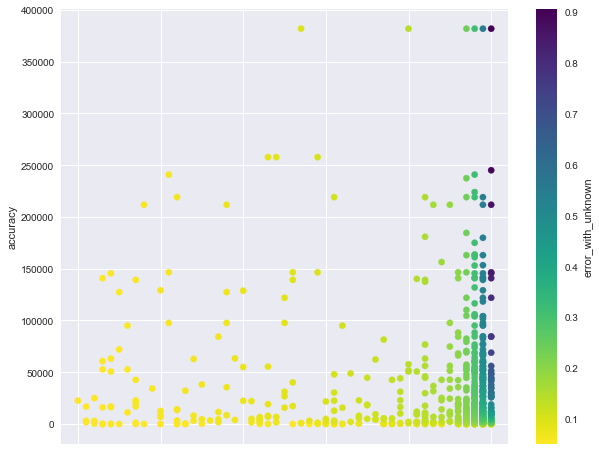

In [72]:
df_error_with_unknown.plot.scatter(x='samples', y='accuracy', c='error_with_unknown', xlim=(48,102), 
                                   cmap=plt.cm.get_cmap('viridis_r'), s=40, figsize=(10,8))

Here, we see the expected trend: the higher either of the parameter values, the higher the `error_with_unknown`.

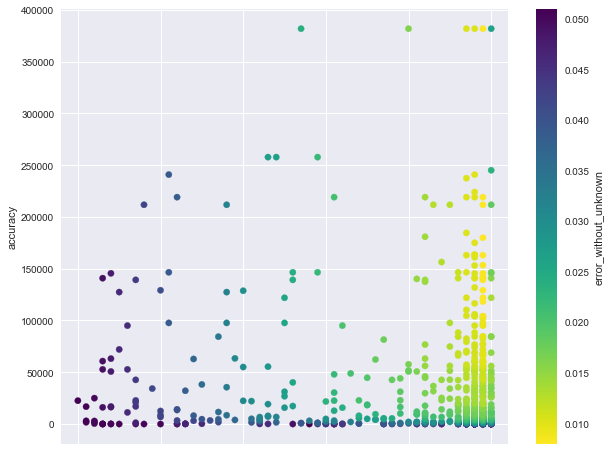

In [73]:
df_error_without_unknown.plot.scatter(x='samples', y='accuracy', c='error_without_unknown', xlim=(48,102), 
                                      cmap=plt.cm.get_cmap('viridis_r'), s=40, figsize=(10,8))

The tendency with the `error_without_unknown` is that the higher both parameter values the lower the error. 
**However, the far right column is not intuitive and needs further exploration.**

## TODO: have a closer look into the wrong classifications